In [28]:
%matplotlib inline

In [29]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path
import torch
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.encoder.encoder import Encoder
from bliss.catalog import TileCatalog
from matplotlib import pyplot as plt

In [30]:
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("base_config", {
        "predict.weight_save_path=/home/regier/bliss_output/jul14_toyexample_ssnmgyfirstrun/version_1/checkpoints/best_encoder.ckpt",
    })

In [31]:

encoder: Encoder = instantiate(cfg.encoder)
weights = torch.load(cfg.predict.weight_save_path)["state_dict"]
encoder.load_state_dict(weights)
encoder.eval()
encoder.cuda()

simulator = instantiate(cfg.simulator)

torch.set_grad_enabled(False);

## One bright (easily detected) star at various positions

Compare samples with independent and dependent tiling

In [32]:
n = 50
n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
n_sources[:, 11, 10] = 1

locs = torch.ones(n, 20, 20, 1, 2) * 0.5
locs[:, 11, 10, 0, 0] = 0.001

source_type = torch.zeros(n, 20, 20, 1, 1, dtype=torch.long)

true_catalog_dict = {
    "n_sources": n_sources,
    "source_type": source_type,
    "locs": locs,
    "star_fluxes": torch.ones(n, 20, 20, 1, 5) * 8,
    "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5),
}
true_catalog = TileCatalog(true_catalog_dict)

In [33]:
rcfs, rcf_indices = simulator.randomized_image_ids(true_catalog["n_sources"].size(0))

In [34]:
images, psf_params = simulator.image_decoder.render_images(
    true_catalog, rcfs, rcf_indices, add_dither=False, add_noise=True
)

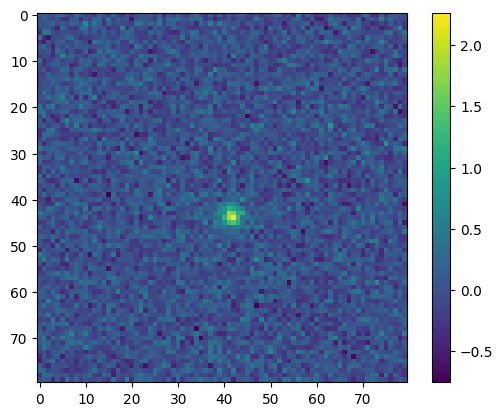

In [35]:
# plot a coadd image
plt.imshow(images[3].sum(0).numpy())
plt.colorbar();

In [36]:
batch = {"images": images.cuda(), "psf_params": psf_params.cuda()}

# comparing joint and marginal

In [37]:
x_cat_marginal, _ = encoder.get_marginal(batch)
pred = encoder.get_predicted_dist(x_cat_marginal)
pred["on_prob"].probs[:, 9:11, 9, 1].sum(1).mean(0)

AttributeError: 'Encoder' object has no attribute 'get_marginal'

In [ ]:
joint_cats = encoder.sample(batch)
(joint_cats["n_sources"][:, 9:11, 9].sum(1) > 0).float().mean()

conclusions
 * In this setting, with one bright star very close to the border, even the *expected number of sources* by marginal isn't well calibrated. It underestimates by at least 5% for a variety of fluxes that are well above the detection limit.
 * Joint is essentially always right is expectation (and in each posterior sample). Though one pixel probability may be miscalibrated, the other makes up for it.